## loading libraries

In [1]:
library(dplyr)
library(doBy)
library(lubridate)
library(ggplot2)
library(Hmisc)
library(zoo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Initial Setup

### Define location of data

In [2]:
#directory<-"/Users/jhosen/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4DHT22/20221110_pull/bin"
directory<-"~/Desktop/data/mesoBinTests/20221110_pull/bin"

### Defining the function for concatenating data within a folder.

In [3]:
concat_run<-function(directory){
    comp_data<-data.frame()
    wb_files<-list.files(path=paste(directory))
    wb_files<-wb_files[wb_files!="notes.txt"]
    for(j in 1:length(wb_files)){
        data<-read.csv(paste(directory,"/",wb_files[j],sep=""))
        data2<-subset(data,type!="debug")
        if(nrow(data2)>0){
            comp_data<-dplyr::bind_rows(comp_data,data2)
        }
    }
    return(comp_data)
}

### Importing the data from a single test run using the function.

In [4]:
comp_data<-concat_run(directory)

## Adding time formats for human readable time and plotting.

In [5]:
comp_data$time_epoch<-as.character(comp_data$time.s)
comp_data$dtp<-lubridate::as_datetime(comp_data$time.s)

### Change relevant columns to factors

In [6]:
comp_data$type<-as.factor(comp_data$type)
comp_data$site<-as.factor(comp_data$site)
comp_data$logger<-as.factor(comp_data$logger)
comp_data$deployment<-as.factor(comp_data$deployment)
comp_data$uuid<-as.factor(comp_data$uuid)

## Function that parses through the data and assigns a burst number and then counts each measurement in a burst.

In [7]:
parse_data<-function(comp_data,burst_interval_threshold,measure_cycle_size){
    comp_data$interval<-comp_data$time.s-Lag(comp_data$time.s,shift=1)

    measurement_cycle<-1
    burst<-1
    reading<-1
    comp_data$measurement_cycle<-1
    comp_data$burst<-1
    comp_data$reading<-1
    comp_rows<-nrow(comp_data)
    
    for(i in 1:comp_rows){
        if(!is.na(comp_data$interval[i])){
            if(comp_data$interval[i]>burst_interval_threshold){
                burst<-burst+1
                reading<-1
                comp_data$burst[i:comp_rows]<-burst
                comp_data$reading[i]<-reading
            }else{
                comp_data$reading[i]<-reading
                reading<-reading+1
            }
            if(burst == measure_cycle_size){
                measurement_cycle<-measurement_cycle+1
                comp_data$measurement_cycle[i:comp_rows]<-measurement_cycle
                burst<-0
            }            
        }
    }
    comp_data$burst<-as.factor(comp_data$burst)
    comp_data$measurement_cycle<-as.factor(comp_data$measurement_cycle)
    return(comp_data)
}

### Function to process each logger individually and output single dataframe

In [8]:
processIndividualLoggers<-function(comp_data,loggerList,loggerLength){
    loggerDataList<-vector("list",loggerCount) #empty list to hold temporary data frames
    
    #subset each logger's data and parse
    for(i in 1:length(loggerList)){
        loggerDataList[[i]]<-parse_data(subset(comp_data,logger==loggerList[i]) ,30,30)
    }
    return(bind_rows(loggerDataList))
}

### Process data and create variables for use later

In [9]:
loggerList<-unique(comp_data$logger) #save each individual logger
loggerCount<-length(loggerList) #how many loggers

processed_data<-processIndividualLoggers(comp_data, loggerList, loggerCount)

### Function to create basic plots of burst vs raw methane reading colored by measurement cycle

In [10]:
cycleVsCH4_plots<-function(processed_data, loggerCount, dataType){
    plots<-vector("list", loggerCount)
    names(plots)<-loggerList
    for(i in 1:loggerCount){
        data<-subset(processed_data,logger==loggerList[i] & type==dataType)
        plots[[i]]<-ggplot(data,aes(burst,ch4_raw))+
        geom_point(aes(color=measurement_cycle))+
        ggtitle(paste("Logger: ",loggerList[i],"\nData type: ", dataType))
    }
    return(plots)
}

### Create plots of raw data and summary data

In [11]:
raw_cycleVsCH4_plots<-cycleVsCH4_plots(processed_data, loggerCount, "raw")
summary_cycleVsCH4_plots<-cycleVsCH4_plots(processed_data, loggerCount, "summary")

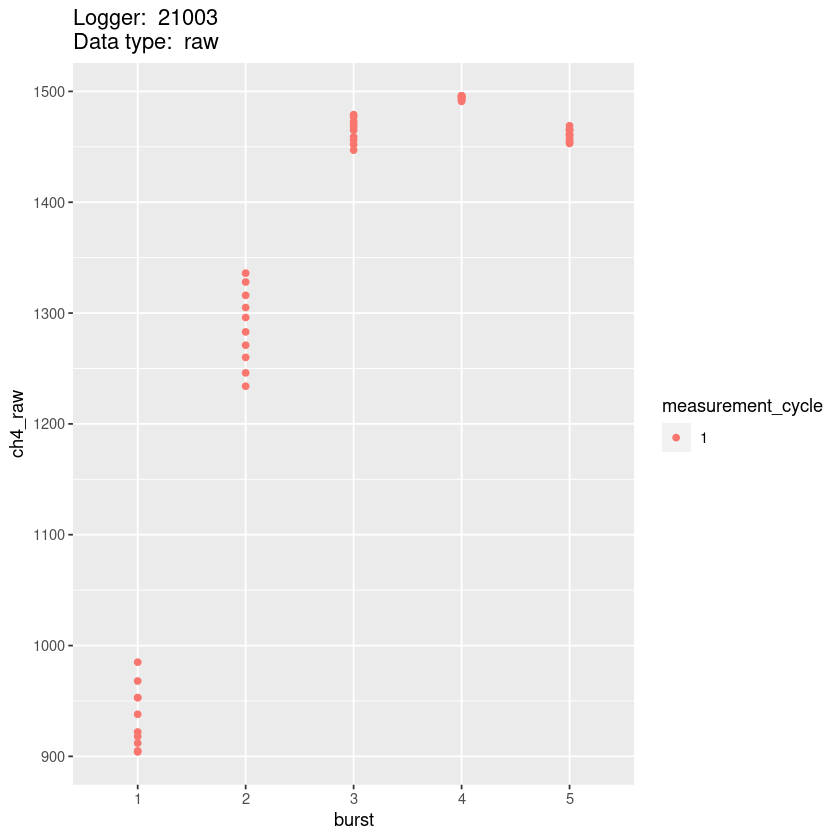

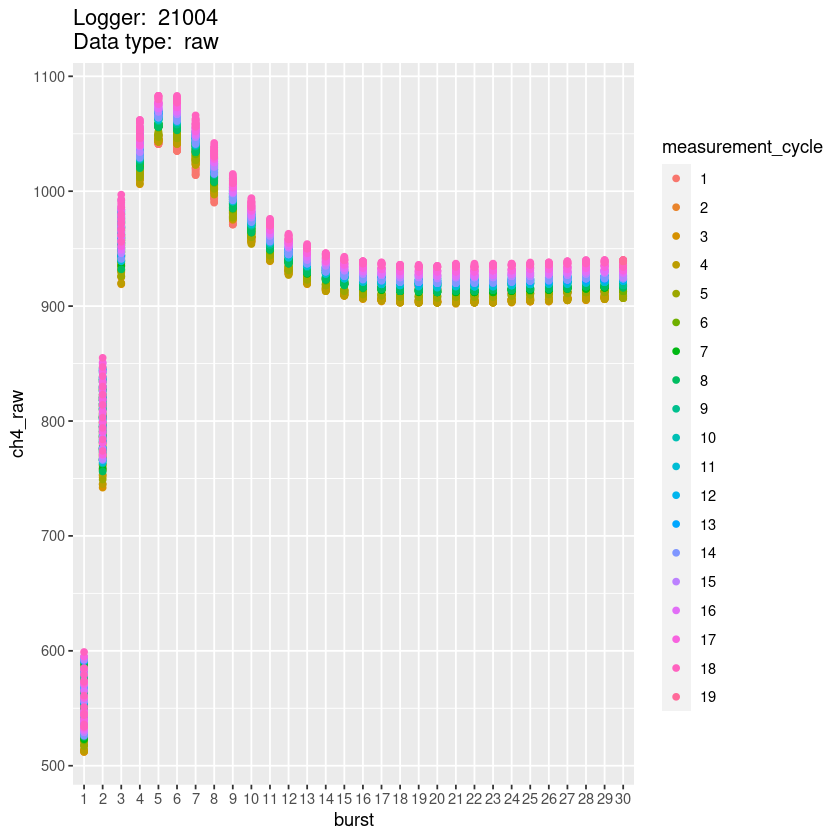

$`21003`

$`21004`

$`21005`

$`21007`


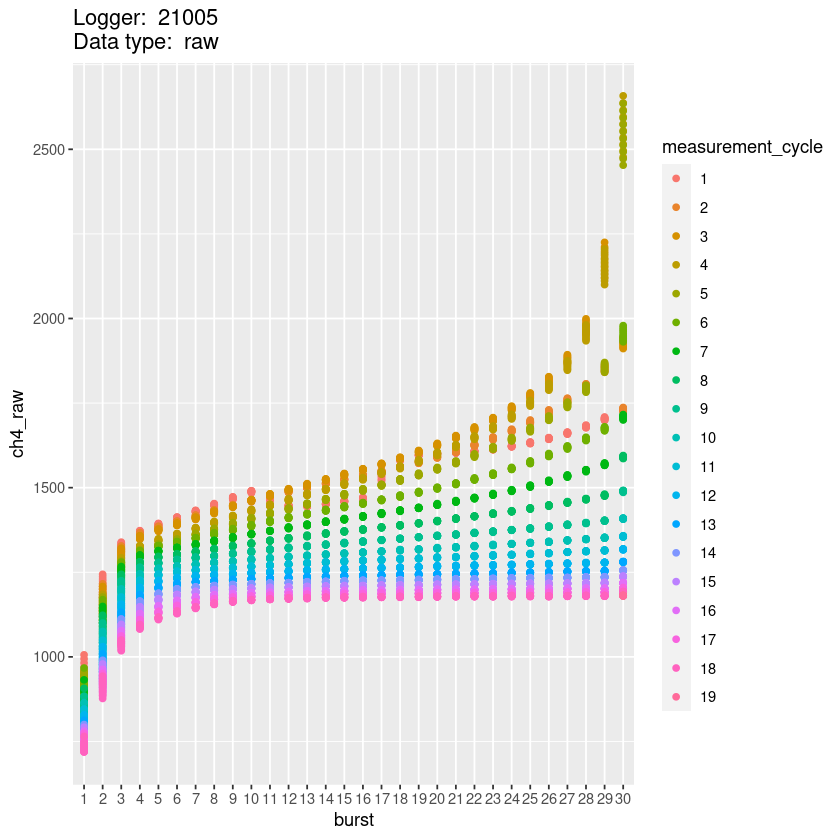

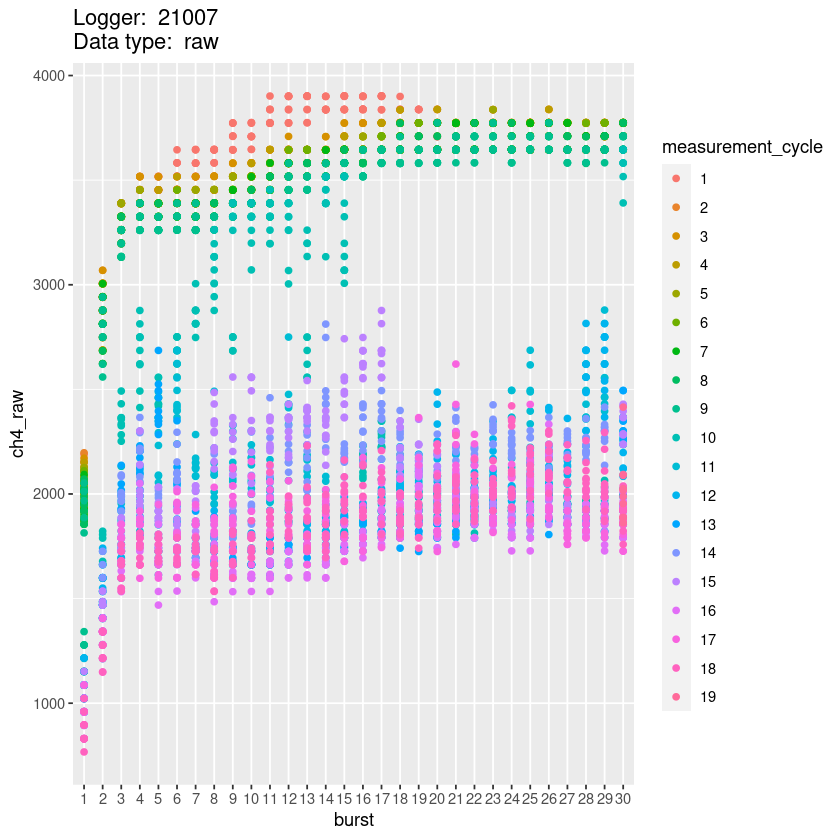

In [12]:
raw_cycleVsCH4_plots

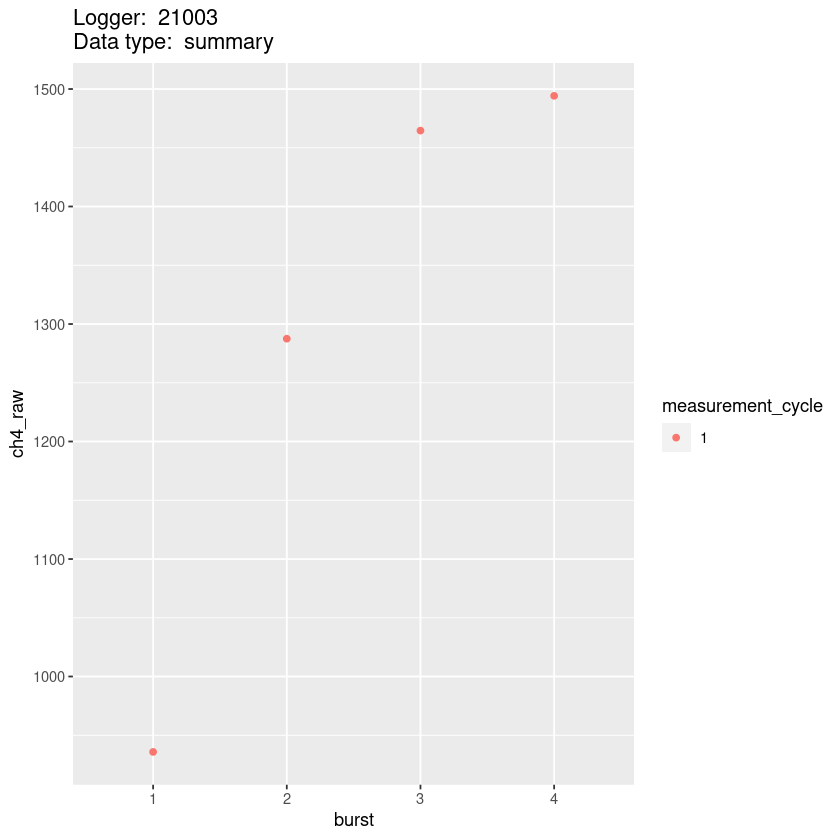

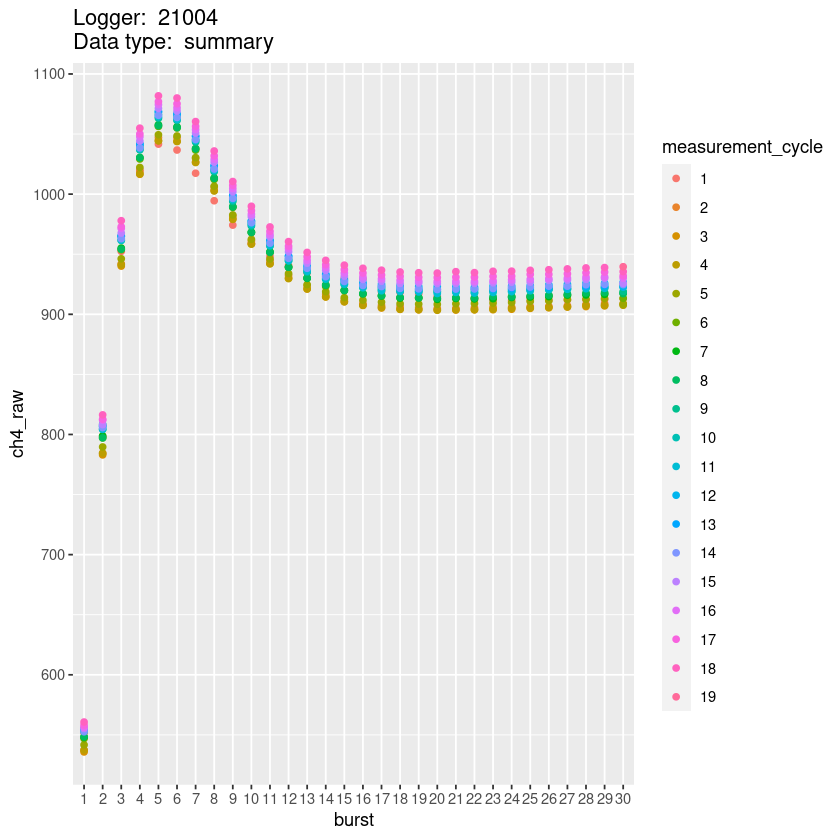

$`21003`

$`21004`

$`21005`

$`21007`


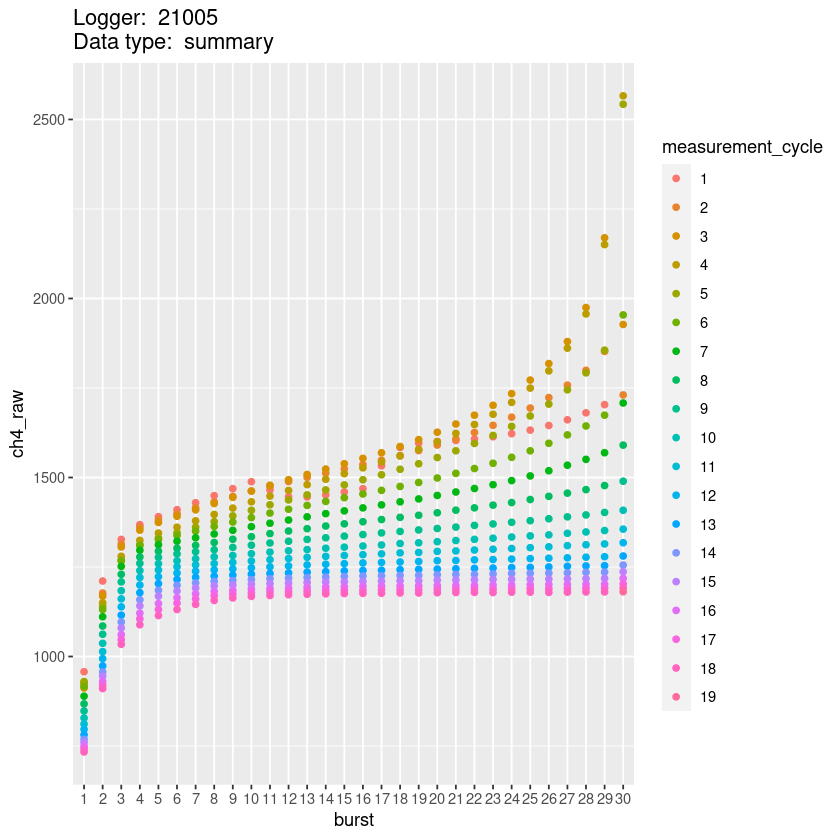

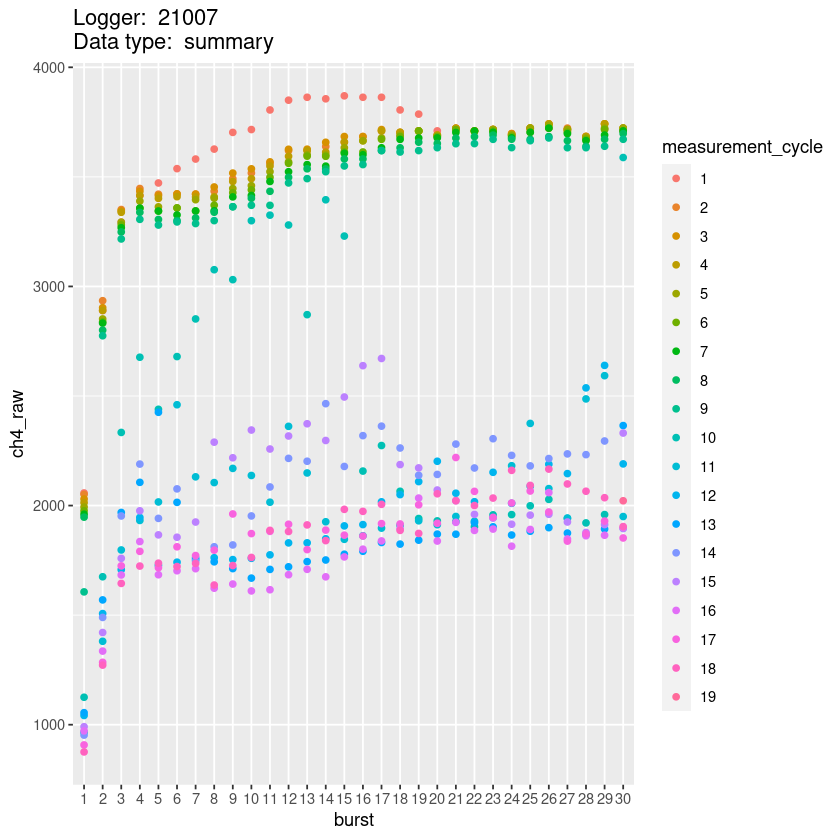

In [13]:
summary_cycleVsCH4_plots

#### Note: you can modify plots after the fact:

In [14]:
#plots[["21003"]]+ggtitle("Overwrite")

## Calculating rolling CV for warm-up detection
Starting with using the summary data for calculations

In [15]:
calculateCV<-function(processed_data, loggerCount, dataType){
    temp_cv<-data.frame()
    calculated_cv_list<-vector("list",loggerCount)
    for(i in 1:loggerCount){
        df<-subset(processed_data, logger==loggerList[i] & type==dataType)

        measurement_cycles<-unique(df$measurement_cycle)
        for(i in 1:length(measurement_cycles)){
            temp<-subset(df,measurement_cycle==measurement_cycles[i])
            temp$roll_mean<-rollapply(data=temp$ch4_raw,width=4,align=c("right"),FUN=mean,fill=NA)
            temp$roll_sd<-rollapply(data=temp$ch4_raw,width=4,align=c("right"),FUN=sd,fill=NA)
            temp$roll_cv<-temp$roll_sd/temp$roll_mean #optionally multiply by 100 for %
            temp_cv<-bind_rows(temp_cv,temp)
        }
        calculated_cv_list[[i]]<-temp_cv
    }
    return(bind_rows(calculated_cv_list))
}

In [16]:
parseSummaryDataCV<-calculateCV(processed_data, loggerCount, "summary")

## Plot rolling cv vs burst cycle and colored by measurement cycle

In [17]:
rollCV_plots<-function(parseDataCV, loggerCount){
    plots<-vector("list", loggerCount)
    names(plots)<-loggerList
    for(i in 1:loggerCount){
        data<-subset(parseDataCV,logger==loggerList[i])
        plots[[i]]<-ggplot(data,aes(burst,roll_cv))+
        geom_point(aes(color=measurement_cycle))+
        scale_y_log10()+
        ggtitle(paste("Rolling CV for Logger: ",loggerList[i]))
    }
    return(plots)
}

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 55 rows containing missing values (geom_point).”


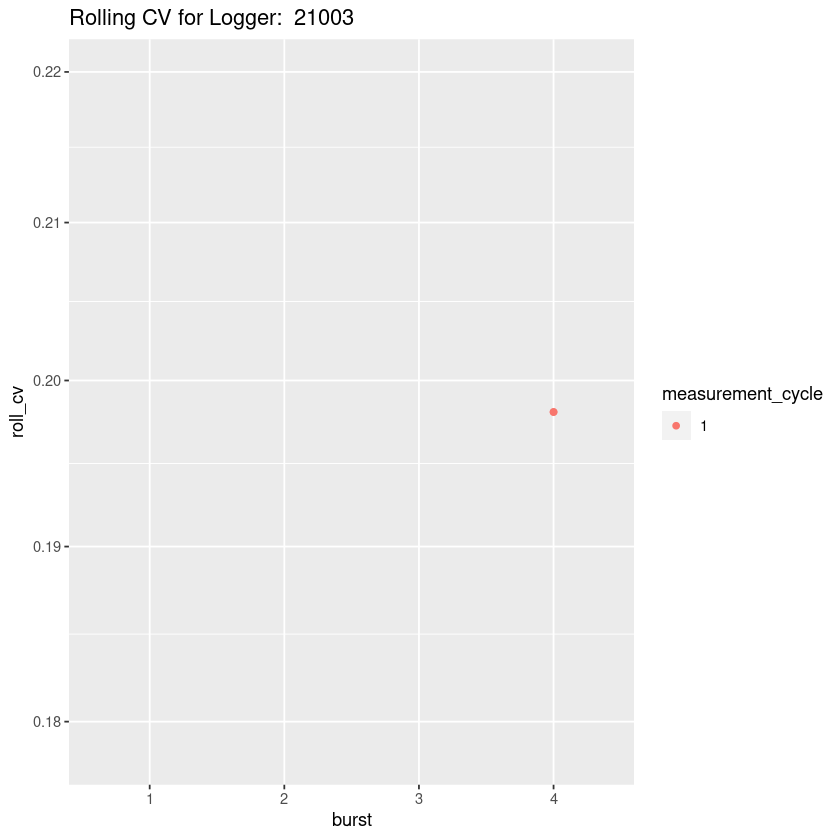

Warning message:
“Removed 55 rows containing missing values (geom_point).”


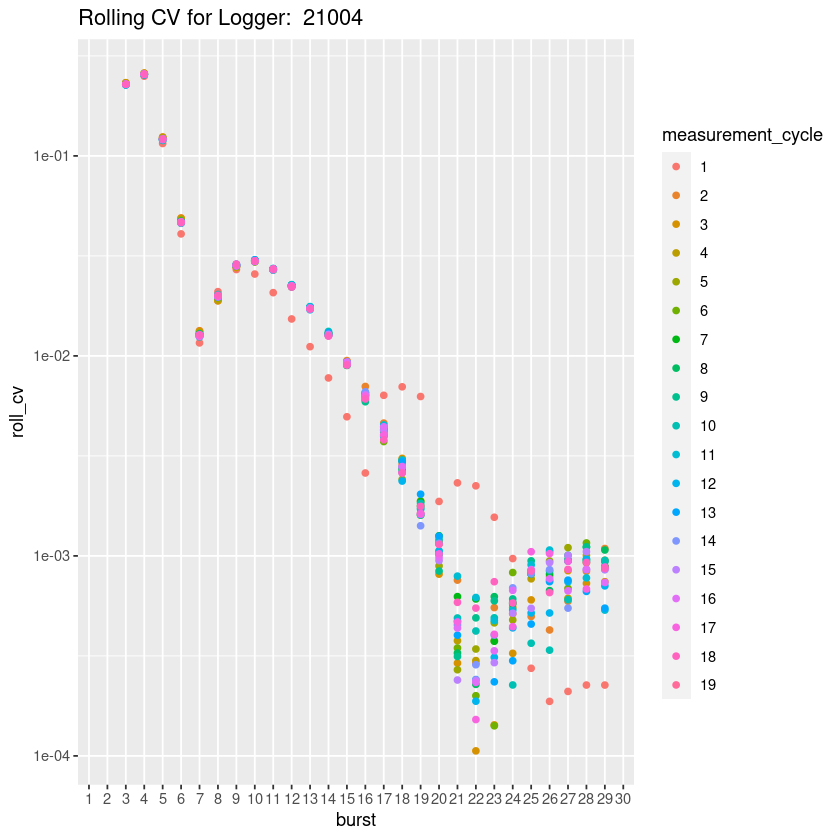

Warning message:
“Removed 55 rows containing missing values (geom_point).”


$`21003`

$`21004`

$`21005`

$`21007`


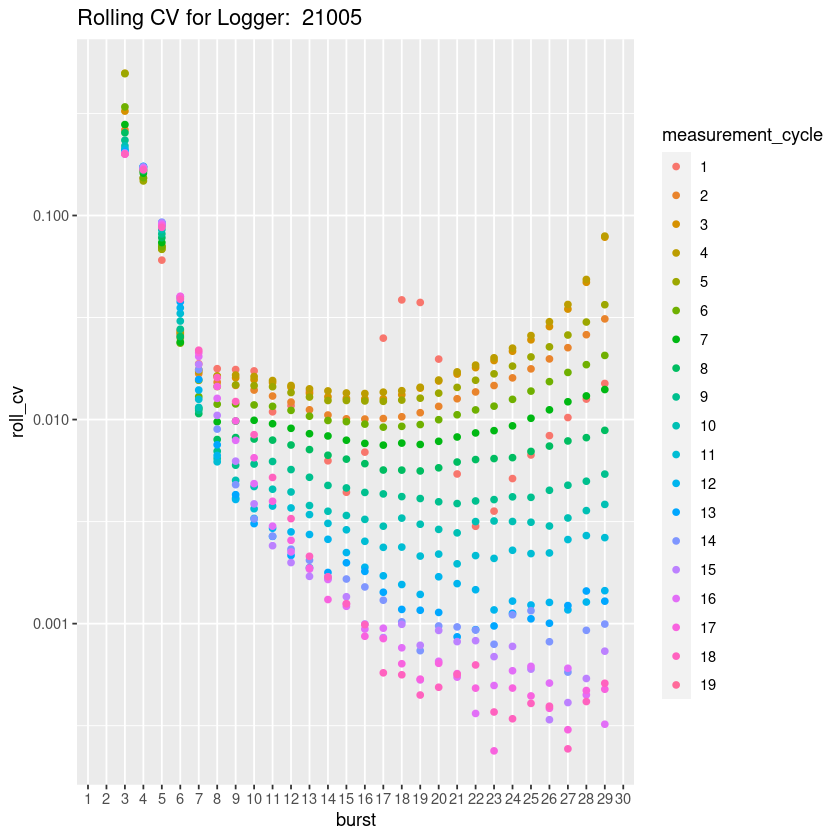

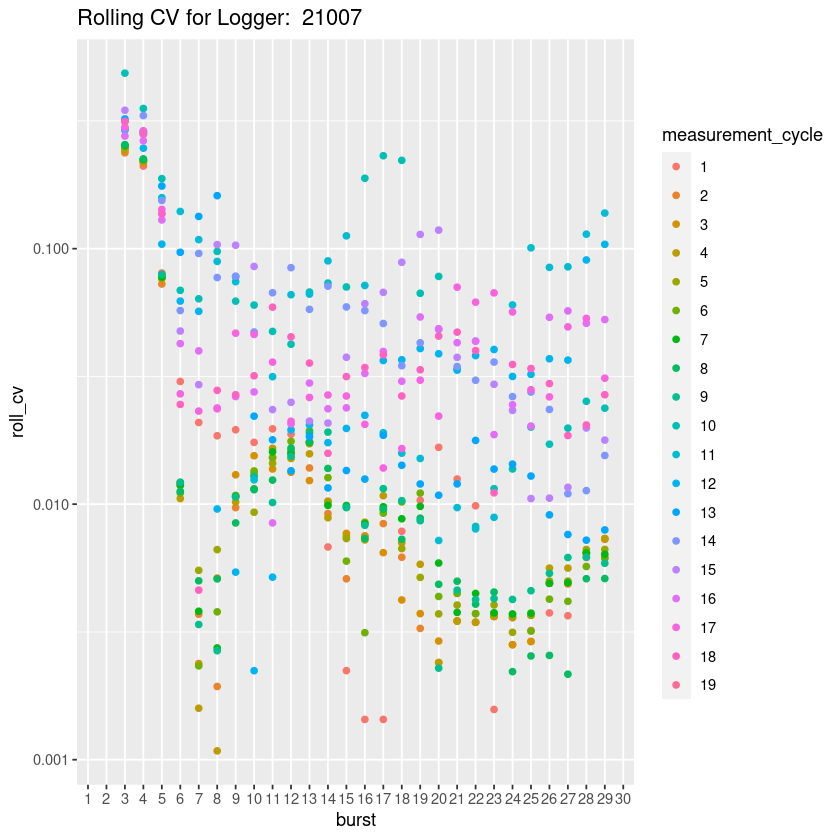

In [18]:
summaryDataCV_plots<-rollCV_plots(parseSummaryDataCV, loggerCount)

summaryDataCV_plots

In [19]:
# comp_parse<-parse_data(subset(comp_data,uuid=="57FF6A068387575136311367"),30,30)
# comp_summary<-subset(comp_parse,type=="summary")
# comp_cv<-data.frame()

# measurement_cycles<-unique(comp_summary$measurement_cycle)
# measurement_cycles



# for(i in 1:length(measurement_cycles)){
#     comp_working<-subset(comp_summary,measurement_cycle==measurement_cycles[i])
#     comp_working$roll_mean<-rollapply(data = comp_working$ch4_raw,width=4,align=c("right"),FUN=mean,fill=NA)
#     comp_working$roll_sd<-rollapply(data = comp_working$ch4_raw,width=4,align=c("right"),FUN=sd,fill=NA)
#     comp_working$roll_cv<-comp_working$roll_sd/comp_working$roll_mean
#     comp_cv<-bind_rows(comp_cv,comp_working)
#     }

# #comp_parse<-subset(comp_parse,measurement_cycle>0)


# ggplot(comp_parse,aes(as.factor(burst),ch4_raw))+
# geom_point(aes(color=as.factor(measurement_cycle)))


# ggplot(comp_cv,aes(as.factor(burst),roll_cv))+
# geom_point(aes(color=as.factor(measurement_cycle)))+
# scale_y_log10()

# comp_cv_57FF6A068387575136311367<-comp_cv



In [20]:
# comp_parse<-parse_data(subset(comp_data,uuid=="50FF74068678545256252467"),30,30)
# comp_summary<-subset(comp_parse,type=="summary")
# comp_cv<-data.frame()

# measurement_cycles<-unique(comp_summary$measurement_cycle)
# measurement_cycles



# for(i in 1:length(measurement_cycles)){
#     comp_working<-subset(comp_summary,measurement_cycle==measurement_cycles[i])
#     comp_working$roll_mean<-rollapply(data = comp_working$ch4_raw,width=4,align=c("right"),FUN=mean,fill=NA)
#     comp_working$roll_sd<-rollapply(data = comp_working$ch4_raw,width=4,align=c("right"),FUN=sd,fill=NA)
#     comp_working$roll_cv<-comp_working$roll_sd/comp_working$roll_mean
#     comp_cv<-bind_rows(comp_cv,comp_working)
#     }

# #comp_parse<-subset(comp_parse,measurement_cycle>0)


# ggplot(comp_parse,aes(as.factor(burst),ch4_raw))+
# geom_point(aes(color=as.factor(measurement_cycle)))


# ggplot(comp_cv,aes(as.factor(burst),roll_cv))+
# geom_point(aes(color=as.factor(measurement_cycle)))+
# scale_y_log10()

# comp_cv_50FF74068678545256252467<-comp_cv


## Calculate the mean of rolling cv above burst 20 for each measurement cycle to determine target cv for methane driver

In [21]:
mean_cv_burst<-function(parseDataCV, loggerList, burstCycleStart){
    mean_na<-function(x){mean(x,na.rm=TRUE)}
    
    loggerCount<-length(loggerList)
    
    temp_mean<-vector("list", loggerCount)
    for(i in 1:loggerCount){
        df<-subset(parseDataCV, logger==loggerList[i] & as.integer(burst)>=burstCycleStart)
        temp_mean[[i]]<-summaryBy(roll_cv~measurement_cycle,df,FUN=c(mean_na))
        temp_mean[[i]]$logger<-unique(df$logger)
        temp_mean[[i]]$deployed_at<-lubridate::as_datetime(unique(df$deployed_at))
    }
    return(bind_rows(temp_mean))
}

#### Removing 21003 as it doesn't have enough bursts to evaluate

In [22]:
loggerList

subsetLoggerList<-loggerList[c(2,3,4)]

subsetLoggerList

[1] 21003 21004 21005 21007
Levels: 21003 21004 21005 21007

[1] 21004 21005 21007
Levels: 21003 21004 21005 21007

In [23]:
meanCVburst<-mean_cv_burst(parseSummaryDataCV, subsetLoggerList, 20)

### Print results

In [24]:
for(i in 1:length(subsetLoggerList)){
    print(subsetLoggerList[i])
    print(subset(meanCVburst, logger==subsetLoggerList[i]))
}

[1] 21004
Levels: 21003 21004 21005 21007
   measurement_cycle roll_cv.mean_na logger         deployed_at
1                  1    0.0010083272  21004 2022-11-09 22:38:46
2                  2    0.0006732790  21004 2022-11-09 22:38:46
3                  3    0.0005382184  21004 2022-11-09 22:38:46
4                  4    0.0006843813  21004 2022-11-09 22:38:46
5                  5    0.0007097636  21004 2022-11-09 22:38:46
6                  6    0.0007258495  21004 2022-11-09 22:38:46
7                  7    0.0007889509  21004 2022-11-09 22:38:46
8                  8    0.0007445993  21004 2022-11-09 22:38:46
9                  9    0.0007635935  21004 2022-11-09 22:38:46
10                10    0.0006031483  21004 2022-11-09 22:38:46
11                11    0.0007708609  21004 2022-11-09 22:38:46
12                12    0.0005909527  21004 2022-11-09 22:38:46
13                13    0.0005597898  21004 2022-11-09 22:38:46
14                14    0.0006910555  21004 2022-11-09 22:38:4

In [25]:
# cv_burst_20<-subset(parseDataCV,logger==21004 & as.integer(burst)>20)

# mean_na<-function(x){mean(x,na.rm=TRUE)}

# test<-summaryBy(roll_cv~measurement_cycle,cv_burst_20,FUN=c(mean_na))
# test$logger<-unique(cv_burst_20$logger)
# test$deployed_at<-lubridate::as_datetime(unique(cv_burst_20$deployed_at))

In [26]:
# comp_cv_burst_20<-subset(comp_cv_50FF74068678545256252467,burst>20)

In [27]:
# mean_na<-function(x){mean(x,na.rm=TRUE)}

# comp_sum_50FF74068678545256252467<-summaryBy(roll_cv~measurement_cycle,comp_cv_burst_20,FUN=c(mean_na))
# comp_sum_50FF74068678545256252467$uuid<-unique(comp_cv_50FF74068678545256252467$uuid)
# comp_sum_50FF74068678545256252467$deployed_at<-lubridate::as_datetime(unique(comp_cv_50FF74068678545256252467$deployed_at))

In [28]:
# head(comp_sum_50FF74068678545256252467)
# saveRDS(comp_sum_50FF74068678545256252467,"comp_sum_50FF74068678545256252467.rds")

In [29]:
# comp_parse<-parse_data(subset(comp_data,uuid=="50FF74068678545256252467"),30,30)
# ggplot(comp_parse,aes(as.factor(burst),atlas_CO2_ppm))+
# geom_point()

### Calculating rolling CV on a measurement cycle.

In [30]:
# head(comp_parse)

In [31]:
# comp_data_sum<-summaryBy(ch4_raw+ch4rf_raw~dtp+uuid,comp_parse,FUN=c(sd,mean))

In [32]:
# head(comp_data_sum)
#comp_parse$dtp

## Plotting average values per burst.

In [33]:
# comp_data_sum$dtp<-as_datetime(comp_data_sum$dtp)

# head(comp_data_sum)

# ggplot(comp_data_sum,aes(dtp,ch4_raw.mean))+
# geom_point()+
# facet_wrap(.~uuid)


# ggplot(comp_data_sum,aes(dtp,ch4rf_raw.mean))+
# geom_point()+
# facet_wrap(.~uuid)

# comp_data_sum$ch4_raw_norm<-comp_data_sum$ch4_raw.mean/comp_data_sum$ch4rf_raw.mean

# ggplot(comp_data_sum,aes(dtp,ch4_raw_norm))+
# geom_point()+
# facet_wrap(.~uuid)

In [34]:
# ggplot(subset(comp_data),aes(dtp,battery.V))+
#     geom_point(aes(color=as.factor(group)))+
# ylim(1500,1650)

In [35]:
# names(comp_data)

In [36]:
# ggplot(comp_data,aes(dtp,atlas_CO2_ppm))+
#        geom_point()

In [37]:
# head(comp_data,n=100)

# File Management

## Function to delete a file if it exists

In [38]:
# check if file at path exists, delete if it does
# will only call in functions that generate new files
cleanFile <-function(path){
  if(file.exists(path)){
    cat(sprintf("Deleting old file: %s\n",path))
    file.remove(path)
  }
}

## Function to create a new directory if it does not exist

In [39]:
# check if directory exists, create if not
newDir <- function(dirPath){
  if(dir.exists(dirPath)){
    cat(sprintf("Output directory, %s, already exists\n", dirPath))
  }
  else{
    cat(sprintf("Output directory not found, creating: %s\n",dirPath))
    dir.create(dirPath)
  }
}

## Function to save a list of plots

In [40]:
#input list of plots, output directory, custom directory path or tag
#output save each plot to output directory
#800 is a little over 5" on my screen at 1920x1080
savePlotList <-function(plotList, outputDir, tag="", width=800, height=800){
  plots <- names(plotList)
  for(i in 1:length(plots)){
    pngPath = paste(sep="",outputDir,tag,plots[i],".png")
    png(file=pngPath,width=width,height=height)
    print(plotList[[ plots[i] ]])
    dev.off()
  }
}

### Saving plots that have been produced so far

In [41]:
#hardcoded custom outputDir
outputDir<-"~/Desktop/data/mesoBinTests/20221110_pull_output/"

newDir(outputDir)

savePlotList(raw_cycleVsCH4_plots, outputDir, "raw_cycleVsCH4_")
savePlotList(summary_cycleVsCH4_plots, outputDir, "summary_cycleVsCH4_")
savePlotList(SummaryDataCV_plots, outputDir, "summaryDataCV_")

Output directory, ~/Desktop/data/mesoBinTests/20221110_pull_output/, already exists


ERROR: Error in savePlotList(SummaryDataCV_plots, outputDir, "summaryDataCV_"): object 'SummaryDataCV_plots' not found


# scratch

In [ ]:
# dir<-'~/Desktop/data/mesoBinTests/20221110_pull/'

In [ ]:
# list.files(path=dir, recursive=TRUE)

In [ ]:
# files<-list.files(path=dir, recursive=TRUE, pattern=".CSV$")

# files

In [ ]:
# exclude<-list("notes.txt","debug.csv","metadata.rtf")

# files<-list.files(path=dir, recursive=TRUE)

# files[!(files %in% exclude)]